## 1) Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from yellowbrick.target import ClassBalance
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.metrics import average_precision_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

warnings.simplefilter('ignore')

## 2) Data preparation

In [7]:
df = pd.read_csv('cs-training.csv').drop(columns = 'Unnamed: 0')
df.SeriousDlqin2yrs = df.SeriousDlqin2yrs.astype('float64')
df.shape

(150000, 11)

Text(0.5, 1.0, 'Data distribution')

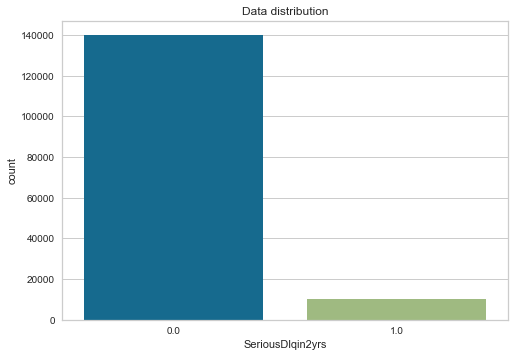

In [8]:
sns.countplot(x="SeriousDlqin2yrs", data=df)
plt.title('Data distribution')

### 2.1) Removing outliers

In [9]:
def remove_outliers(df):
    df = df.loc[df['RevolvingUtilizationOfUnsecuredLines'] < 13]
    df = df.loc[df['age'] >= 20]
    df = df.loc[df['NumberOfTimes90DaysLate'] < 18]
    df = df[df['NumberOfTime30-59DaysPastDueNotWorse'] < 96]
    df = df.loc[df['DebtRatio'] <= df['DebtRatio'].quantile(0.975)]
    return df


df1 = remove_outliers(df)
df1.shape

(145754, 11)

### 2.2) Removing duplicates

In [10]:
df1.duplicated().value_counts()

False    145189
True        565
dtype: int64

In [11]:
df1 = df1.drop_duplicates()

### 2.2) Filling Null Values

In [12]:
df1.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           25520
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3568
dtype: int64

In [13]:
df1['NumberOfDependents'].fillna(0,inplace=True)

In [14]:
def knn_imputation(df):
    imputer = KNNImputer(n_neighbors=3)
    df_imputed = imputer.fit_transform(df)
    df = pd.DataFrame(df_imputed, columns=df.columns)
    return df 

df2 = knn_imputation(df1)

In [15]:
df2.isna().sum().sum()

0

### 2.3) Balancing dataset

In [24]:
X = df2.drop(columns='SeriousDlqin2yrs')
y = df2[['SeriousDlqin2yrs']]

over = SMOTE(sampling_strategy=0.1,k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X, y)

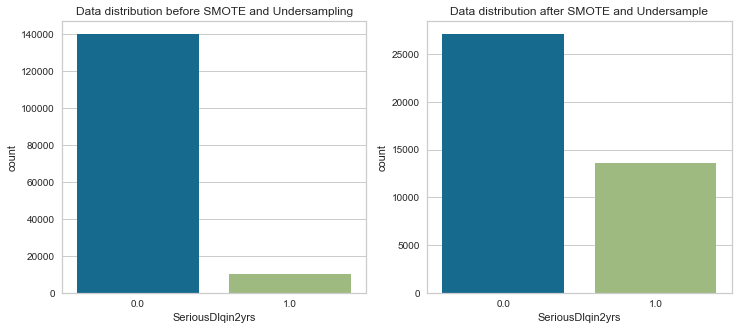

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x="SeriousDlqin2yrs", data=df)
plt.title('Data distribution before SMOTE and Undersampling')

plt.subplot(1, 2, 2)
sns.countplot(x="SeriousDlqin2yrs", data=y)
plt.title('Data distribution after SMOTE and Undersample')

plt.show()

## 3) Modelling

In [26]:
def Precision_Recall_Curve(clf, X_train, y_train, X_test, y_test):
    
    y_pred = clf.predict_proba(X_test)
    auc_score = average_precision_score(y_test, y_pred[:, 1])
    print('AUC: ', auc_score)
    visualizer = PrecisionRecallCurve(clf)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

AUC:  0.860123712757862


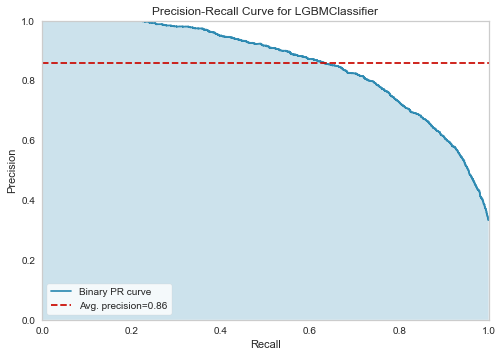

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=12)

clf = LGBMClassifier(objective='binary',
                     is_unbalance=True,
                     metric='average_precision')
clf.fit(X_train, y_train)
Precision_Recall_Curve(clf, X_train, y_train, X_test, y_test)

### 3.1) Hyperparameter tuning

#### 3.1.1) num_estimators

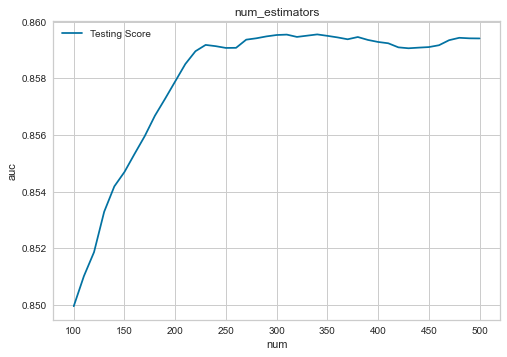

In [59]:
num_estimators = range(100, 501, 10)
test_scores = []
for num_estimator in num_estimators:
    lgbm = LGBMClassifier(objective = 'binary',
                          is_unbalance = True,
                          metric='average_precision',
                          num_leaves=60,
                          learning_rate=0.02,
                          n_estimators=num_estimator)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict_proba(X_test)
    auc_score = average_precision_score(y_test, y_pred[:, 1])
    test_scores.append(auc_score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(num_estimators, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('num_estimators')
ax.legend(loc='best')
plt.show()

In [60]:
num_estimators = num_estimators[test_scores.index(max(test_scores))]
num_estimators

340

#### 3.1.2) learning_rates

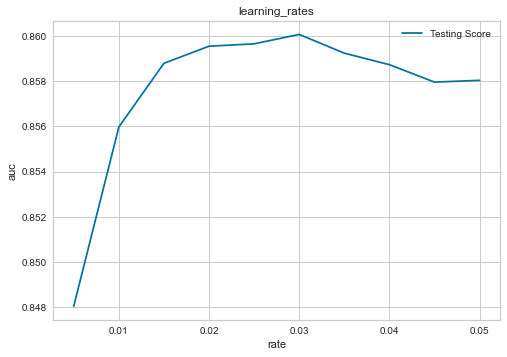

In [61]:
learning_rates = np.arange(1, 11, 1)
learning_rates = learning_rates / 200.0
test_scores = []
for learning_rate in learning_rates:
    lgbm = LGBMClassifier(objective='binary',
                          is_unbalance=True,
                          metric='average_precision',
                          num_leaves=60,
                          learning_rate=learning_rate,
                          n_estimators=num_estimators)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict_proba(X_test)
    auc_score = average_precision_score(y_test, y_pred[:, 1])
    test_scores.append(auc_score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(learning_rates, test_scores, label='Testing Score')
ax.set_xlabel(r'rate')
ax.set_ylabel(r'auc')
ax.set_title('learning_rates')
ax.legend(loc='best')
plt.show()

In [62]:
learning_rate = learning_rates[test_scores.index(max(test_scores))]
learning_rate

0.03

#### 3.1.3) max_bins

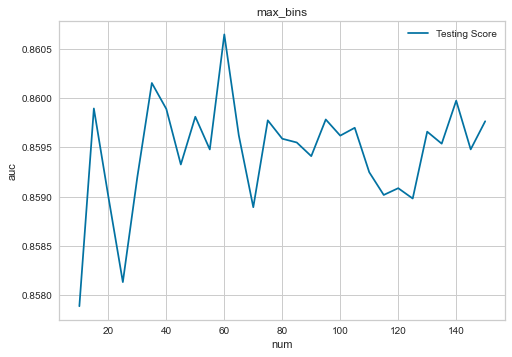

In [63]:
max_bins = range(10, 151, 5)
test_scores = []
for max_bin in max_bins:
    lgbm = LGBMClassifier(objective = 'binary',
                          is_unbalance = True,
                          metric='average_precision',
                          max_bin=max_bin,
                          num_leaves=60,
                          learning_rate=learning_rate,
                          n_estimators=num_estimators)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict_proba(X_test)
    auc_score = average_precision_score(y_test, y_pred[:, 1])
    test_scores.append(auc_score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(max_bins, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('max_bins')
ax.legend(loc='best')
plt.show()

In [64]:
max_bin = max_bins[test_scores.index(max(test_scores))]
max_bin

60

#### 3.1.4) num_leaves

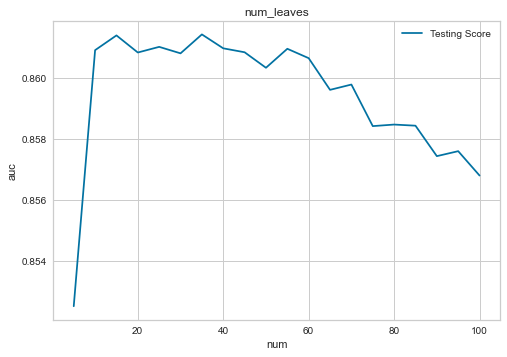

In [65]:
num_leaves = range(5, 101, 5)
test_scores = []
for num_leave in num_leaves:
    lgbm = LGBMClassifier(objective = 'binary',
                          is_unbalance = True,
                          metric='average_precision',
                          num_leaves=num_leave,
                          max_bin=max_bin,
                          learning_rate=learning_rate,
                          n_estimators=num_estimators)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict_proba(X_test)
    auc_score = average_precision_score(y_test, y_pred[:, 1])
    test_scores.append(auc_score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(num_leaves, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('num_leaves')
ax.legend(loc='best')
plt.show()

In [66]:
num_leaves = num_leaves[test_scores.index(max(test_scores))]
num_leaves

35

#### 3.1.5) max_depth

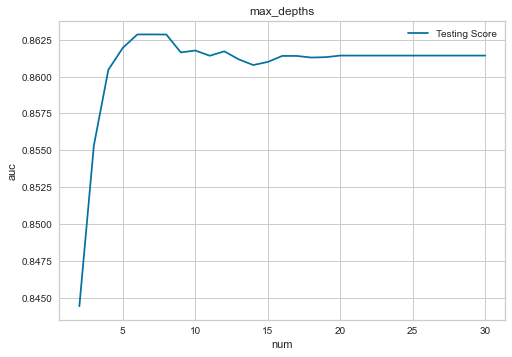

In [67]:
max_depths = range(2, 31, 1)
test_scores = []
for max_depth in max_depths:
    lgbm = LGBMClassifier(objective = 'binary',
                          is_unbalance = True,
                          metric='average_precision',
                          max_depth=max_depth,
                          num_leaves=num_leaves,
                          max_bin=max_bin,
                          learning_rate=learning_rate,
                          n_estimators=num_estimators)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict_proba(X_test)
    auc_score = average_precision_score(y_test, y_pred[:, 1])
    test_scores.append(auc_score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(max_depths, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('max_depths')
ax.legend(loc='best')
plt.show()

In [68]:
max_depth = max_depths[test_scores.index(max(test_scores))]
max_depth

7

#### 3.1.6) feature_fractions

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

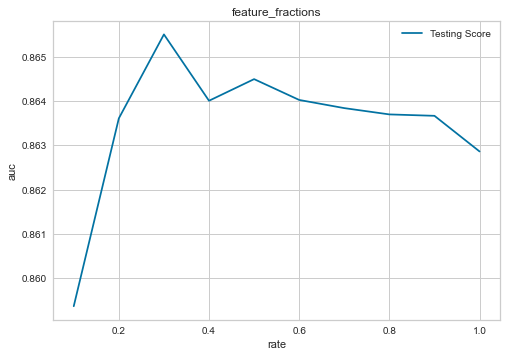

In [69]:
feature_fractions = np.arange(1, 11, 1)
feature_fractions = feature_fractions / 10.0
test_scores = []
for feature_fraction in feature_fractions:
    lgbm = LGBMClassifier(objective = 'binary',
                          is_unbalance = True,
                          metric='average_precision',
                          max_depth=max_depth,
                          num_leaves=num_leaves,
                          max_bin=max_bin,
                          learning_rate=learning_rate,
                          n_estimators=num_estimators,
                          feature_fraction=feature_fraction)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict_proba(X_test)
    auc_score = average_precision_score(y_test, y_pred[:, 1])
    test_scores.append(auc_score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(feature_fractions, test_scores, label='Testing Score')
ax.set_xlabel(r'rate')
ax.set_ylabel(r'auc')
ax.set_title('feature_fractions')
ax.legend(loc='best')
plt.show()

In [70]:
feature_fraction = feature_fractions[test_scores.index(max(test_scores))]
feature_fraction

0.3

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
AUC:  0.8650199938082961


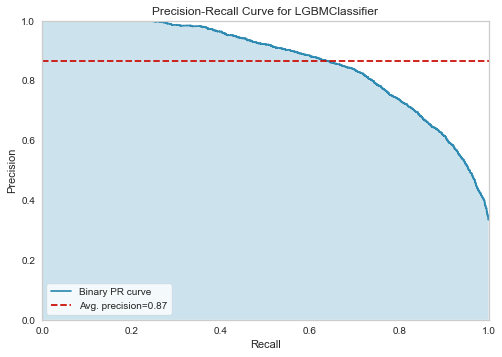

In [71]:
clf_tuned = LGBMClassifier(objective='binary',
                           is_unbalance=True,
                           metric='average_precision',
                           max_depth=max_depth,
                           num_leaves=num_leave,
                           max_bin=max_bin,
                           learning_rate=learning_rate,
                           n_estimators=num_estimator,
                           feature_fraction=feature_fraction)

clf_tuned.fit(X_train, y_train)
Precision_Recall_Curve(clf_tuned, X_train, y_train, X_test, y_test)

### 3.2) Calibration

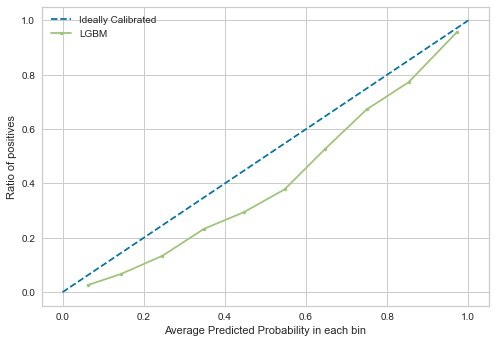

In [72]:
def Calibration_Curve(clf,X_test,y_test):
    probs = clf.predict_proba(X_test)[:,1]
    fop, mpv = calibration_curve(y_test, probs, n_bins=10)
    plt.plot([0, 1], [0, 1], linestyle='--',label = 'Ideally Calibrated')
    plt.plot(mpv, fop, marker='.',label = 'LGBM')
    leg = plt.legend(loc = 'upper left')
    plt.xlabel('Average Predicted Probability in each bin')
    plt.ylabel('Ratio of positives')
    plt.show()
    
Calibration_Curve(clf_tuned,X_test,y_test)

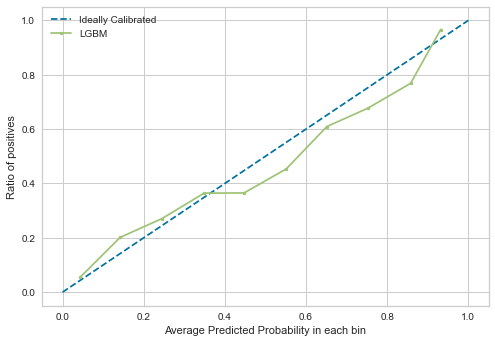

In [73]:
clf_calibrated = CalibratedClassifierCV(clf_tuned, cv='prefit')
clf_calibrated.fit(X_train, y_train)
Calibration_Curve(clf_calibrated,X_test,y_test)

AUC:  0.8650199938082961


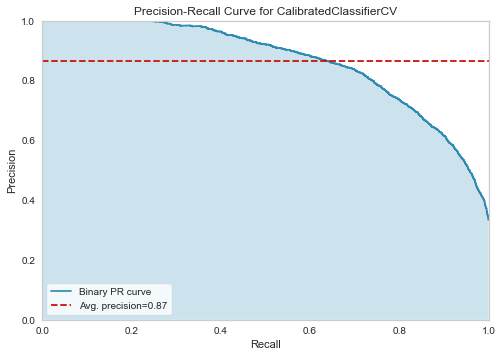

In [74]:
Precision_Recall_Curve(clf_calibrated, X_train, y_train, X_test, y_test)

## 4) Evaluation

In [75]:
test = pd.read_csv('cs-test.csv').drop(columns = 'Unnamed: 0')
y_pred = clf_calibrated.predict_proba(test.drop(columns='SeriousDlqin2yrs'))
submission = pd.read_csv('sampleEntry.csv')
submission['Probability'] = y_pred
submission['Probability'] = 1-submission['Probability'] 
submission.to_csv('submission.csv',index=False)